### 多値分類モデル　改訂版

### 必要ライブラリの導入

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib -qq

In [2]:
# 共通事前処理

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.2f}'.format

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

### データ準備

#### データ読み込み

In [3]:
from sklearn.datasets import load_iris

# アイリスデータセットをロード
iris = load_iris(as_frame=True)

df = iris.data
df.columns = ['がく片長', 'がく片幅', '花弁長', '花弁幅']
display(df.head())

,がく片長,がく片幅,花弁長,花弁幅
0,5.10,3.50,1.40,0.20
1,4.90,3.00,1.40,0.20
2,4.70,3.20,1.30,0.20
3,4.60,3.10,1.50,0.20
4,5.00,3.60,1.40,0.20


#### データ絞り込み

In [4]:
# データ絞り込み
#   クラスはすべて
#   項目がく片長と花弁長のみ
x_data = df[['がく片長','花弁長']].values
y_data = iris.target.values

print('x_data')
print(f'shape: {x_data.shape}')
print(f'先頭5行:\n{x_data[:5]}\n')

print('y_data')
print(f'shape: {y_data.shape}')
print(f'先頭5行:\n{y_data[:5]}')

x_data
shape: (150, 2)
先頭5行:
[[5.1 1.4]
 [4.9 1.4]
 [4.7 1.3]
 [4.6 1.5]
 [5.  1.4]]

y_data
shape: (150,)
先頭5行:
[0 0 0 0 0]


### 散布図表示

 #### y_dataの値でデータ分割

In [5]:
x_t0 = x_data[y_data == 0]
x_t1 = x_data[y_data == 1]
x_t2 = x_data[y_data == 2]

#### 散布図表示

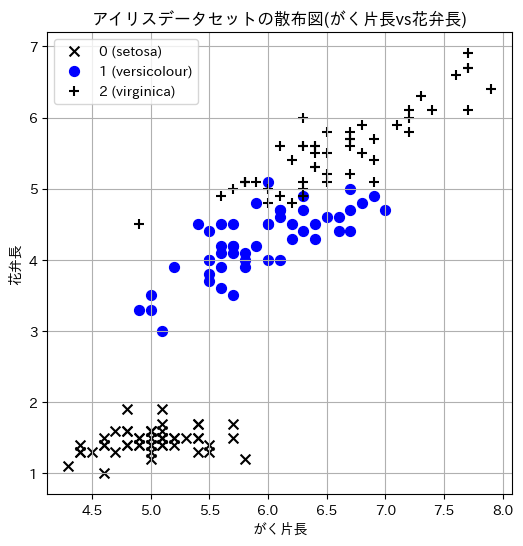

In [6]:
# グラフのサイズ指定
plt.figure(figsize=(6,6))

# マーカを変えて散布図表示
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')

# グラフのキレイ化
plt.title('アイリスデータセットの散布図(がく片長vs花弁長)')
plt.xlabel('がく片長')
plt.ylabel('花弁長')
plt.legend()
plt.grid()
plt.show()

### データ前処理

#### xにダミー変数の追加

In [7]:
# ダミー変数を追加
x_data2 = np.insert(x_data, 0, 1.0, axis=1)

print('ダミー変数追加後')
print(x_data2.shape)
print(x_data2[:5])

ダミー変数追加後
(150, 3)
[[1.  5.1 1.4]
 [1.  4.9 1.4]
 [1.  4.7 1.3]
 [1.  4.6 1.5]
 [1.  5.  1.4]]


#### yをOne hot vectorに

In [8]:
from sklearn.preprocessing import OneHotEncoder

# y_dataの行列化
y_data_matrix = y_data.reshape(-1,1)

# one hot encoderインスタンスの生成
ohe = OneHotEncoder(sparse_output=False,categories='auto')

# y_data_magtrixのone hot encoding
y_data_ohe = ohe.fit_transform(y_data_matrix)

# 各変数のshape確認
print('オリジナル', y_data.shape)
print('２次元化', y_data_matrix.shape)
print('One Hot Vector化後', y_data_ohe.shape)

オリジナル (150,)
２次元化 (150, 1)
One Hot Vector化後 (150, 3)


#### 訓練データ・テストデータへの分割

In [9]:
# 学習データ、検証データに分割
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, y_train_ohe, y_test_ohe = train_test_split(
    x_data2, y_data, y_data_ohe, train_size=75, test_size=75, random_state=123)

In [10]:
# 各変数のshape確認
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_train_ohe', y_train_ohe.shape)
print('y_test_ohe', y_test_ohe.shape)

x_train (75, 3)
x_test (75, 3)
y_train (75,)
y_test (75,)
y_train_ohe (75, 3)
y_test_ohe (75, 3)


In [11]:
# xtrainの内容確認
print(x_train[:5])

[[1.  6.3 4.7]
 [1.  7.  4.7]
 [1.  5.  1.6]
 [1.  6.4 5.6]
 [1.  6.3 5. ]]


In [12]:
# y_trainの内容確認
print(y_train[:5])

[1 1 0 2 2]


In [13]:
# y_train_oheの内容確認
print(y_train_ohe[:5])

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


### 学習準備

#### 学習用変数の設定

In [14]:
# 学習対象の選択
x, yt  = x_train, y_train_ohe

### 関数定義

#### softmax関数

In [15]:
def softmax(x):
    x = x.T
    x_max = x.max(axis=0)
    x = x - x_max
    w = np.exp(x)
    return (w / w.sum(axis=0)).T

#### 予測関数

In [16]:
def pred(x, W):
    return softmax(x @ W)

#### 損失関数(交差エントロピー関数)

In [17]:
def cross_entropy(yt, yp):
    return -np.mean(np.sum(yt * np.log(yp), axis=1))

#### evaluate(損失と精度を計算)

In [18]:
# モデルの評価を行う関数
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_ohe, W):

    # 予測値の計算(確率値)
    yp_test_ohe = pred(x_test, W)

    # 確率値から予測クラス(0, 1, 2)を導出
    yp_test = np.argmax(yp_test_ohe, axis=1)

    # 損失関数値の計算
    loss = cross_entropy(y_test_ohe, yp_test_ohe)

    # 精度の算出
    score = accuracy_score(y_test, yp_test)
    return loss, score

 ### 学習

#### 初期設定

In [19]:
# 標本数
M  = x.shape[0]
# 入力次元数(ダミー変数を含む
D = x.shape[1]
# 分類先クラス数
N = yt.shape[1]

# 繰り返し回数
iters = 10000

# 学習率
alpha = 0.01

# 重み行列の初期設定(すべて1)
W = np.ones((D, N))

# 評価結果記録用
history = np.zeros((0, 3))

#### 繰り返し処理

In [20]:
for k in range(iters):

    # 予測値の計算 (9.7.1)　(9.7.2)
    yp = pred(x, W)

    # 誤差の計算 (9.7.4)
    yd = yp - yt

    # 重みの更新 (9.7.5)
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_ohe, W)
        history = np.vstack((history, np.array([k, loss, score])))
        print(f"epoch = {k} loss = {loss:.04f} score = {score:.04f}")

epoch = 0 loss = 1.0926 score = 0.2667
epoch = 10 loss = 1.0640 score = 0.2667
epoch = 20 loss = 1.0335 score = 0.2667
epoch = 30 loss = 1.0026 score = 0.2667
epoch = 40 loss = 0.9735 score = 0.2667
epoch = 50 loss = 0.9463 score = 0.3867
epoch = 60 loss = 0.9210 score = 0.5600
epoch = 70 loss = 0.8974 score = 0.6000
epoch = 80 loss = 0.8755 score = 0.6133
epoch = 90 loss = 0.8550 score = 0.6267
epoch = 100 loss = 0.8359 score = 0.6267
epoch = 110 loss = 0.8182 score = 0.6267
epoch = 120 loss = 0.8015 score = 0.6267
epoch = 130 loss = 0.7860 score = 0.6267
epoch = 140 loss = 0.7714 score = 0.6400
epoch = 150 loss = 0.7578 score = 0.6533
epoch = 160 loss = 0.7449 score = 0.6800
epoch = 170 loss = 0.7329 score = 0.7067
epoch = 180 loss = 0.7215 score = 0.7600
epoch = 190 loss = 0.7108 score = 0.7867
epoch = 200 loss = 0.7007 score = 0.7867
epoch = 210 loss = 0.6911 score = 0.8000
epoch = 220 loss = 0.6820 score = 0.8000
epoch = 230 loss = 0.6734 score = 0.8133
epoch = 240 loss = 0.6652 s

### 結果分析

#### 損失・精度確認

In [21]:
print(f'初期状態: 損失関数:{history[0,1]:.04f} 精度:{history[0,2]:.04f}')
print(f'最終状態: 損失関数:{history[-1,1]:.04f} 精度:{history[-1,2]:.04f}')

初期状態: 損失関数:1.0926 精度:0.2667
最終状態: 損失関数:0.1979 精度:0.9600


 #### 学習曲線表示(損失)

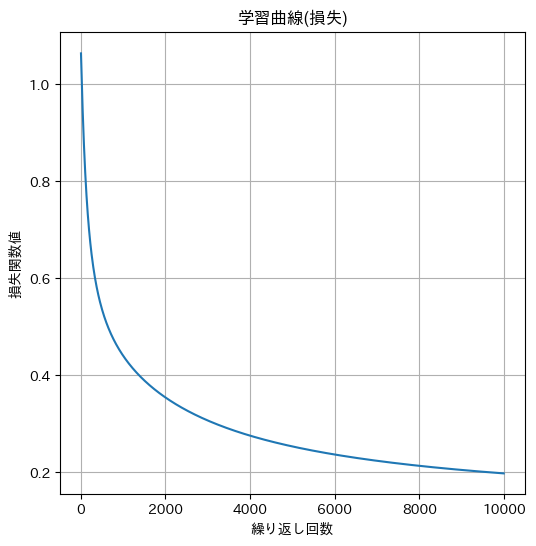

In [22]:
# グラフのサイズ指定
plt.figure(figsize=(6,6))

# 学習曲線の表示 (最初の1個分を除く)
plt.plot(history[1:,0], history[1:,1])

# グラフのキレイ化
plt.title('学習曲線(損失)')
plt.grid()
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.show()

#### 学習曲線表示(精度)

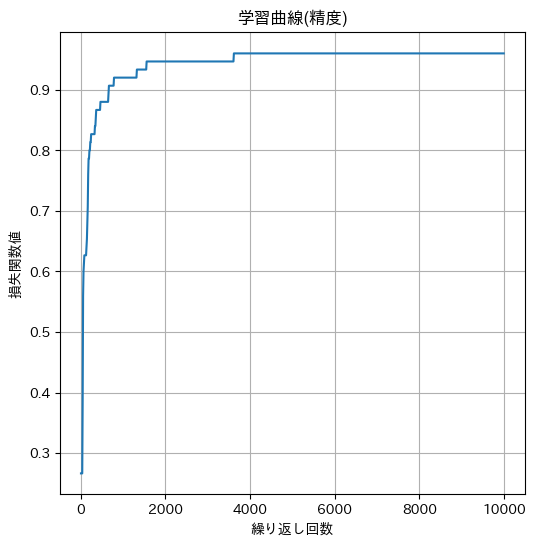

In [23]:
# グラフのサイズ指定
plt.figure(figsize=(6,6))

# 学習曲線の表示 (最初の1個分を除く)
plt.plot(history[1:,0], history[1:,2])

# グラフのキレイ化
plt.title('学習曲線(精度)')
plt.grid()
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.show()

#### 予測関数の3次元曲面表示

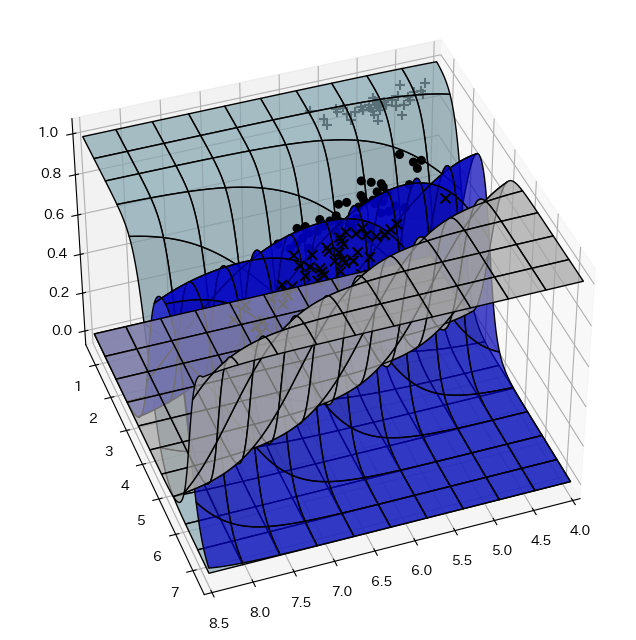

In [24]:
# 3次元表示
from mpl_toolkits.mplot3d import Axes3D
x1 = np.linspace(4, 8.5, 100)
x2 = np.linspace(0.5, 7.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.array([np.ones(xx1.ravel().shape),
    xx1.ravel(), xx2.ravel()]).T
pp = pred(xxx, W)
c0 = pp[:,0].reshape(xx1.shape)
c1 = pp[:,1].reshape(xx1.shape)
c2 = pp[:,2].reshape(xx1.shape)
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c0, color='lightblue',
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c1, color='blue',
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c2, color='lightgrey',
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.scatter(x_t0[:,0], x_t0[:,1], 1, s=50, alpha=1, marker='+', c='k')
ax.scatter(x_t1[:,0], x_t1[:,1], 1, s=30, alpha=1, marker='o', c='k')
ax.scatter(x_t2[:,0], x_t2[:,1], 1, s=50, alpha=1, marker='x', c='k')
ax.set_xlim(4,8.5)
ax.set_ylim(0.5,7.5)
ax.view_init(elev=40, azim=70)

#### 詳細な精度評価

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# テストデータで予測値の計算
yp_test_one = pred(x_test, W)
yp_test = np.argmax(yp_test_one, axis=1)

#  精度の計算
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, yp_test)
print('accuracy: %f' % score)

# 混同行列の表示
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, yp_test))
print(classification_report(y_test, yp_test))

accuracy: 0.960000
[[27  0  0]
 [ 0 20  0]
 [ 0  3 25]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.87      1.00      0.93        20
           2       1.00      0.89      0.94        28

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.97      0.96      0.96        75



### 入力変数をオリジナルの4つに変更

#### x_data4の準備

In [26]:
# x_data3: 4要素を持つNumPy配列
x_data3 = df[['がく片長', 'がく片幅', '花弁長', '花弁幅']].values

# ダミー変数を追加
x_data4 = np.insert(x_data3, 0, 1.0, axis=1)

# 結果確認
print(x_data4.shape)
print(x_data4[:5])

(150, 5)
[[1.  5.1 3.5 1.4 0.2]
 [1.  4.9 3.  1.4 0.2]
 [1.  4.7 3.2 1.3 0.2]
 [1.  4.6 3.1 1.5 0.2]
 [1.  5.  3.6 1.4 0.2]]


#### 訓練データ・テストデータへの分割

In [27]:
# 学習データ、検証データに分割
from sklearn.model_selection import train_test_split

x_train2, x_test2, y_train, y_test, y_train_ohe, y_test_ohe = train_test_split(
    x_data4, y_data, y_data_ohe, train_size=75, test_size=75, random_state=123)

In [28]:
# 各変数のshape確認
print('x_train2', x_train2.shape)
print('x_test2', x_test2.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_train_ohe', y_train_ohe.shape)
print('y_test_ohe', y_test_ohe.shape)

x_train2 (75, 5)
x_test2 (75, 5)
y_train (75,)
y_test (75,)
y_train_ohe (75, 3)
y_test_ohe (75, 3)


In [29]:
# xtrainの内容確認
print(x_train2[:5])

[[1.  6.3 3.3 4.7 1.6]
 [1.  7.  3.2 4.7 1.4]
 [1.  5.  3.  1.6 0.2]
 [1.  6.4 2.8 5.6 2.1]
 [1.  6.3 2.5 5.  1.9]]


#### 学習対象の選択

In [30]:
x, yt, x_test  = x_train2, y_train_ohe, x_test2

#### 初期設定

In [31]:
# 標本数
M  = x.shape[0]
# 入力次元数(ダミー変数を含む
D = x.shape[1]
# 分類先クラス数
N = yt.shape[1]

# 繰り返し回数
iters = 10000

# 学習率
alpha = 0.01

# 重み行列の初期設定(すべて1)
W = np.ones((D, N))

# 評価結果記録用
history = np.zeros((0, 3))

#### 繰り返し処理

In [32]:
for k in range(iters):

    # 予測値の計算
    yp = pred(x, W)

    # 誤差の計算
    yd = yp - yt

    # 重みの更新
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_ohe, W)
        history = np.vstack((history, np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f" % (k, loss, score))

epoch = 0 loss = 1.091583 score = 0.266667
epoch = 10 loss = 1.041711 score = 0.266667
epoch = 20 loss = 0.988501 score = 0.266667
epoch = 30 loss = 0.939962 score = 0.573333
epoch = 40 loss = 0.897037 score = 0.626667
epoch = 50 loss = 0.859177 score = 0.626667
epoch = 60 loss = 0.825724 score = 0.626667
epoch = 70 loss = 0.796070 score = 0.626667
epoch = 80 loss = 0.769683 score = 0.653333
epoch = 90 loss = 0.746103 score = 0.653333
epoch = 100 loss = 0.724936 score = 0.693333
epoch = 110 loss = 0.705850 score = 0.746667
epoch = 120 loss = 0.688561 score = 0.760000
epoch = 130 loss = 0.672832 score = 0.760000
epoch = 140 loss = 0.658461 score = 0.786667
epoch = 150 loss = 0.645275 score = 0.786667
epoch = 160 loss = 0.633131 score = 0.786667
epoch = 170 loss = 0.621903 score = 0.813333
epoch = 180 loss = 0.611485 score = 0.813333
epoch = 190 loss = 0.601788 score = 0.840000
epoch = 200 loss = 0.592731 score = 0.840000
epoch = 210 loss = 0.584248 score = 0.880000
epoch = 220 loss = 0.

#### 損失・精度確認

In [33]:
print(f'初期状態: 損失関数:{history[0,1]:.04f} 精度:{history[0,2]:.04f}')
print(f'最終状態: 損失関数:{history[-1,1]:.04f} 精度:{history[-1,2]:.04f}')

初期状態: 損失関数:1.0916 精度:0.2667
最終状態: 損失関数:0.1372 精度:0.9600


#### 学習曲線表示(損失)

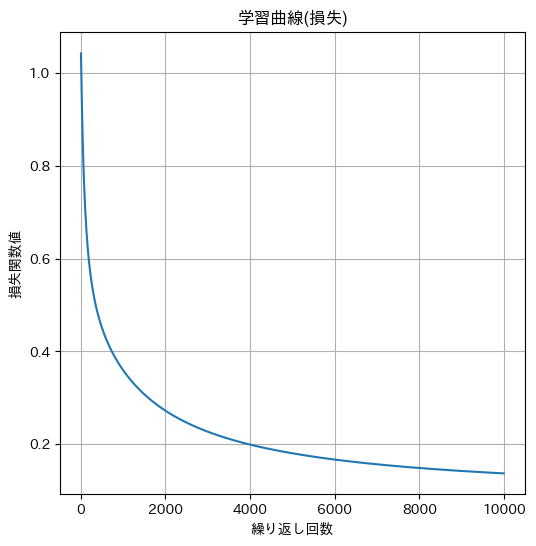

In [34]:
# グラフのサイズ指定
plt.figure(figsize=(6,6))

# 学習曲線の表示 (最初の1個分を除く)
plt.plot(history[1:,0], history[1:,1])

# グラフのキレイ化
plt.title('学習曲線(損失)')
plt.grid()
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.show()

#### 学習曲線表示(精度)

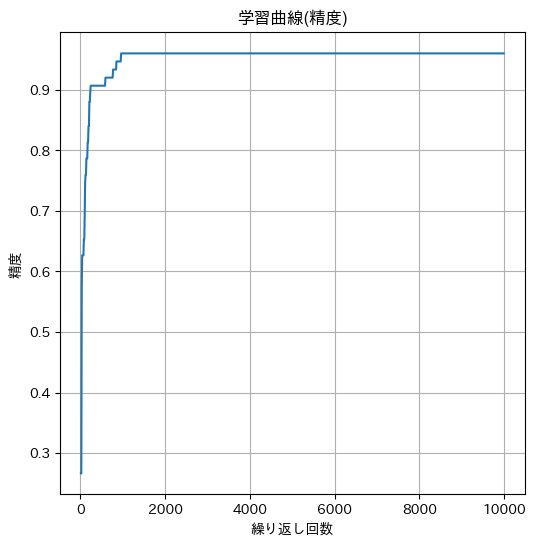

In [35]:
# グラフのサイズ指定
plt.figure(figsize=(6,6))

# 学習曲線の表示 (最初の1個分を除く)
plt.plot(history[1:,0], history[1:,2])

# グラフのキレイ化
plt.title('学習曲線(精度)')
plt.grid()
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.show()

### バージョン確認

In [36]:
!pip install watermark -qq
%load_ext watermark
%watermark --iversions

sklearn            : 1.6.0
numpy              : 1.26.4
japanize_matplotlib: 1.1.3
matplotlib         : 3.8.0
pandas             : 2.2.2
IPython            : 7.34.0

